## Multiple Shooting methods for ODEs

In [1]:
from sys import path ; path.append("../..")
import torchdyn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45, MSZero, MSBackward
from torchdyn.numerics import odeint, odeint_mshooting, Lorenz

import time 
%load_ext autoreload
%autoreload 2

In [2]:
# quick run for automated notebook validation
dry_run = False

In [3]:
x0 = torch.randn(1, 3) + 15
t_span = torch.linspace(0, 3, 3000)
sys = Lorenz()

In [4]:
t0 = time.time()
t_eval_ms, ms_sol = odeint_mshooting(sys, x0, t_span[::4], solver='mszero', fine_steps=2, maxiter=5)
ms_sol_time = time.time() - t0

In [5]:
t0 = time.time()
t_eval, accurate_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-6, rtol=1e-6)#, interpolator='4th')
accurate_sol_time = time.time() - t0

t0 = time.time()
t_eval, base_sol = odeint(sys, x0, t_span, solver='euler')
base_sol_time = time.time() - t0

t0 = time.time()
t_eval, rk4_sol = odeint(sys, x0, t_span, solver='rk4')
rk4_sol_time = time.time() - t0

t0 = time.time()
t_eval, dp5_low_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-3, rtol=1e-3, interpolator='4th')
dp5_low_time = time.time() - t0

In [6]:
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

Text(0.5, 1.0, 'Wall-clock sol time')

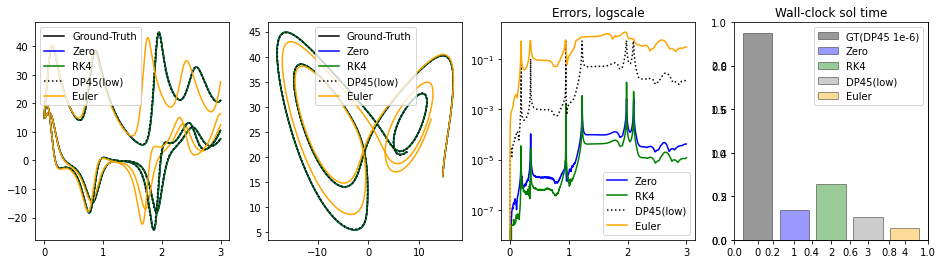

In [11]:
err_zero = smape(ms_sol, accurate_sol[::4]).mean(1).sum(1)
err_base = smape(base_sol, accurate_sol).mean(1).sum(1)
err_rk4 = smape(rk4_sol, accurate_sol).mean(1).sum(1)
err_dp5 = smape(dp5_low_sol, accurate_sol).mean(1).sum(1)

fig, axs = plt.subplots(1, 4, figsize=(16,4))
# = fig.add_subplot(1,4,1)
for i in range(len(x0)):
    for j in range(3):
        axs[0].plot(t_eval, accurate_sol[:,i,j], 'black')
        axs[0].plot(t_eval_ms, ms_sol[:,i,j], 'blue')
        axs[0].plot(t_eval, rk4_sol[:,i,j], 'green')        
        axs[0].plot(t_eval, dp5_low_sol[:,i,j], ':k')
        axs[0].plot(t_eval, base_sol[:,i,j], c='orange')
        axs[0].legend(['Ground-Truth', 'Zero', 'RK4', 'DP45(low)', 'Euler',])
        
for i in range(len(x0)):
    axs[1].plot(accurate_sol[:,i,0], accurate_sol[:,i,2], 'k')
    axs[1].plot(ms_sol[:,i,0], ms_sol[:,i,2], 'b')
    axs[1].plot(rk4_sol[:,i,0], rk4_sol[:,i,2], 'g')
    axs[1].plot(dp5_low_sol[:,i,0], dp5_low_sol[:,i,2], ':k')
    axs[1].plot(base_sol[:,i,0], base_sol[:,i,2], c='orange')
    axs[1].legend(['Ground-Truth', 'Zero', 'RK4', 'DP45(low)', 'Euler'])

axs[2].plot(t_eval_ms, err_zero, 'b')
axs[2].plot(t_eval, err_rk4, 'green')
axs[2].plot(t_eval, err_dp5, ':k')
axs[2].plot(t_eval, err_base, 'orange')
axs[2].set_yscale('log')
axs[2].legend(['Zero', 'RK4', 'DP45(low)', 'Euler'])
axs[2].set_title('Errors, logscale')

times = [accurate_sol_time, ms_sol_time, rk4_sol_time, dp5_low_time, base_sol_time]
ax = fig.add_subplot(1,4,4)
colors = ['k', 'b', 'g', 'grey', 'orange']
for k in range(5):
    barlist = ax.bar(0 + k, times[k:k+1], color=colors[k], alpha=0.4, edgecolor='black')
ax.legend(['GT(DP45 1e-6)', 'Zero', 'RK4', 'DP45(low)', 'Euler'])
ax.set_title('Wall-clock sol time')